In [147]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import pandas as pd
import geopandas as gpd
import geoplot as gplt
import matplotlib.pyplot as plt

In [108]:
# We read in the dataframe for predictions
df = pd.read_csv(f"../data/curated/future_prediction_data.csv")

In [109]:
df

,Unnamed: 0,suburb,clearance,avg_days_on_market,3_year_growth,2019_n_sold,2022_n_sold,2022_median,2022_growth,suburb_population,new_dwellings_2019,non_residential_value_2019,new_dwellings_2021,non_residential_value_2021
0,0,abbotsford,0.507077,71.774359,0.176514,195.0,294.0,7.657590e+05,0.049467,9241.878946,3.755102,6.669155e+06,4.047096,7.697972e+07
1,1,aberfeldie,0.637714,46.742857,0.399867,35.0,49.0,1.962143e+06,0.205971,2462.173913,0.000000,0.000000e+00,10.195652,1.585941e+06
2,2,aintree,0.400000,35.940476,0.235013,84.0,143.0,7.098214e+05,0.097869,256.025000,6.437500,2.231975e+05,4.337500,7.999375e+04
3,3,aireys-inlet,0.000000,35.000000,0.708938,16.0,22.0,1.935000e+06,0.423000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00
4,4,airport-west,0.659863,59.397260,0.174302,146.0,186.0,8.415274e+05,0.067705,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1191,1191,yarroweyah,0.000000,0.000000,0.000000,0.0,0.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00
1192,1192,yellingbo,0.000000,0.000000,0.000000,0.0,0.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00
1193,1193,yelta,0.000000,0.000000,0.000000,0.0,0.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00
1194,1194,yinnar-south,0.000000,0.000000,0.000000,0.0,0.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00


## Fit linear regression component

In [110]:
# For the linear model, exclude 0 clearance rate and no new building locations.
df = df[df["clearance"] != 0]
df = df[df["new_dwellings_2019"] != 0]

In [111]:
X = df[["2019_n_sold", "suburb_population", "new_dwellings_2019", "non_residential_value_2019"]]
y = df["3_year_growth"]

In [113]:
# Fit a linear model to the data
reg = LinearRegression().fit(X,y)
reg.score(X,y)

0.06037531038345845

Clearly, using a linear regression on historical data is not a valid method, so we will have to try another method to predict future value.
Instead we will have to take a non-statistical approach, and use the suburb metrics that we have access to.

## Predictor Metrics:

Median Price: Due to current rising interest rates, properties that are more expensive, and thus put the purchaser into more debt are likely to see less growth than cheaper areas. This should also have a runoff effect to cost of rent in the area.

Historical 3-year-growth: While a regression to the mean is fairly likely in many cases, a suburb having a high growth rate in previous years should still indicate that that is more likely to continue.

Current growth rate: Extrapolating the 2022 growth rate to a 3 year prediction is unlikely to be accurate, but it is once again a decent indicator.

New dwellings / population: If there is a high number of new dwellings relative to the population, then in theory the increased supply will lead to decreased house value.

non residential value: The theory behind using this metric, is that non-residential housing indicates an increase in local business. This should in theory increase the value of the area. This may be incorrect, as it might indicate a non-residential area, but not sure.

Clearance: A high clearance rate should indicate a high demand in the area, so in theory an increase in future prices.

Average days on market: A low number of days on the market, should indicate (like clearance), a high demand for houses in the area.

sold / population: If there are a high number of sales relative to the population it indicates market interest.

Unfortunately due to a lack of historical data for many areas, and many of these metrics, we will have to decide aribtrarily on the importance of each feature. I will then create a ranking of each feature and use this as the input for the algorithm.

https://propertyupdate.com.au/property-investment-melbourne/#is-it-the-right-time-to-get-into-the-melbourne-property-market

https://www.trilogyfunding.com.au/blog/7-key-market-indicators-every-property-investor-should-understand-april-2015/


https://www.mmj.com.au/resources/blog/5-key-market-indicators-every-property-investor-should-know/

In [139]:
df = pd.read_csv(f"../data/curated/future_prediction_data.csv")

predict_df = pd.DataFrame()
predict_df["suburb"] = df["suburb"]
predict_df["avg_days_on_market"] = df["avg_days_on_market"].rank(ascending = False) # low is better
predict_df["3_year_growth"] = df["3_year_growth"].rank(ascending = True) # high is better
predict_df["2022_growth"] = df["2022_growth"].rank(ascending = True) # high is better
predict_df["sold/pop"] = (df["2022_n_sold"]/df["suburb_population"]).rank(ascending = True).fillna(0) # high is better
predict_df["dwellings/pop"] = (df["new_dwellings_2021"]/df["suburb_population"]).rank(ascending = False).fillna(0) # low is better
predict_df["non_residential_value"] = df["non_residential_value_2021"].rank(ascending = True) # higher is better
predict_df["clearance"] = df["clearance"].rank(ascending = True) # higher is better
predict_df["sum"] = predict_df.sum(axis=1)
predict_df["SA2"] = df["SA2"]

/tmp/ipykernel_136/3891181513.py:12: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  predict_df["sum"] = predict_df.sum(axis=1)


In [173]:
predict_df = predict_df.sort_values(by="sum", ascending=False)
predict_df.to_csv(f"../data/curated/prediction_results.csv")

In [174]:
predict_df

,suburb,avg_days_on_market,3_year_growth,2022_growth,sold/pop,dwellings/pop,non_residential_value,clearance,sum,SA2
402,flinders,907.0,1172.0,1175.0,132.0,262.0,1190.0,1188.5,6026.5,203021043.0
119,blairgowrie,452.0,1176.0,1116.0,450.0,162.5,1031.0,1154.0,5541.5,214021383.0
1068,tootgarook,489.0,1097.0,1142.0,453.0,162.5,958.0,1060.5,5362.0,214021383.0
681,mccrae,402.0,1170.0,997.0,333.0,205.0,1052.0,1181.0,5340.0,202011018.0
729,mornington,435.0,1042.0,889.0,399.0,289.0,1115.0,1161.0,5330.0,213051582.0
...,...,...,...,...,...,...,...,...,...,...
815,nungurner,907.0,322.5,280.0,0.0,0.0,363.0,436.5,2309.0,NaN
1195,yuroke,907.0,322.5,280.0,0.0,0.0,363.0,436.5,2309.0,NaN
367,elmore,7.0,322.5,280.0,151.0,81.0,894.0,436.5,2172.0,207011147.0
1188,yarrambat,9.0,322.5,280.0,637.5,0.0,363.0,436.5,2048.5,NaN


We can then see the ranking of suburbs. Flinders, Blairgowrie, tootgarook, mccrae, and mornington take the top spots.

In [141]:
shape = gpd.read_file('../data/raw/ShapeFile/SA2_2021_AUST_GDA2020.shp')
shape = shape.loc[shape.STE_NAME21 == "Victoria"]
shape = shape.loc[shape.geometry != None]
shape["SA2_CODE21"] = pd.to_numeric(shape["SA2_CODE21"], errors='ignore')
plot_df = predict_df.join(shape[["SA2_CODE21", "geometry"]].set_index("SA2_CODE21"), on="SA2")
plot_df = plot_df[plot_df["geometry"] != None]

/home/dylan/.local/lib/python3.8/site-packages/geoplot/geoplot.py:885: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in geom:
/home/dylan/.local/lib/python3.8/site-packages/geoplot/geoplot.py:982: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in geom:


<AxesSubplot:>

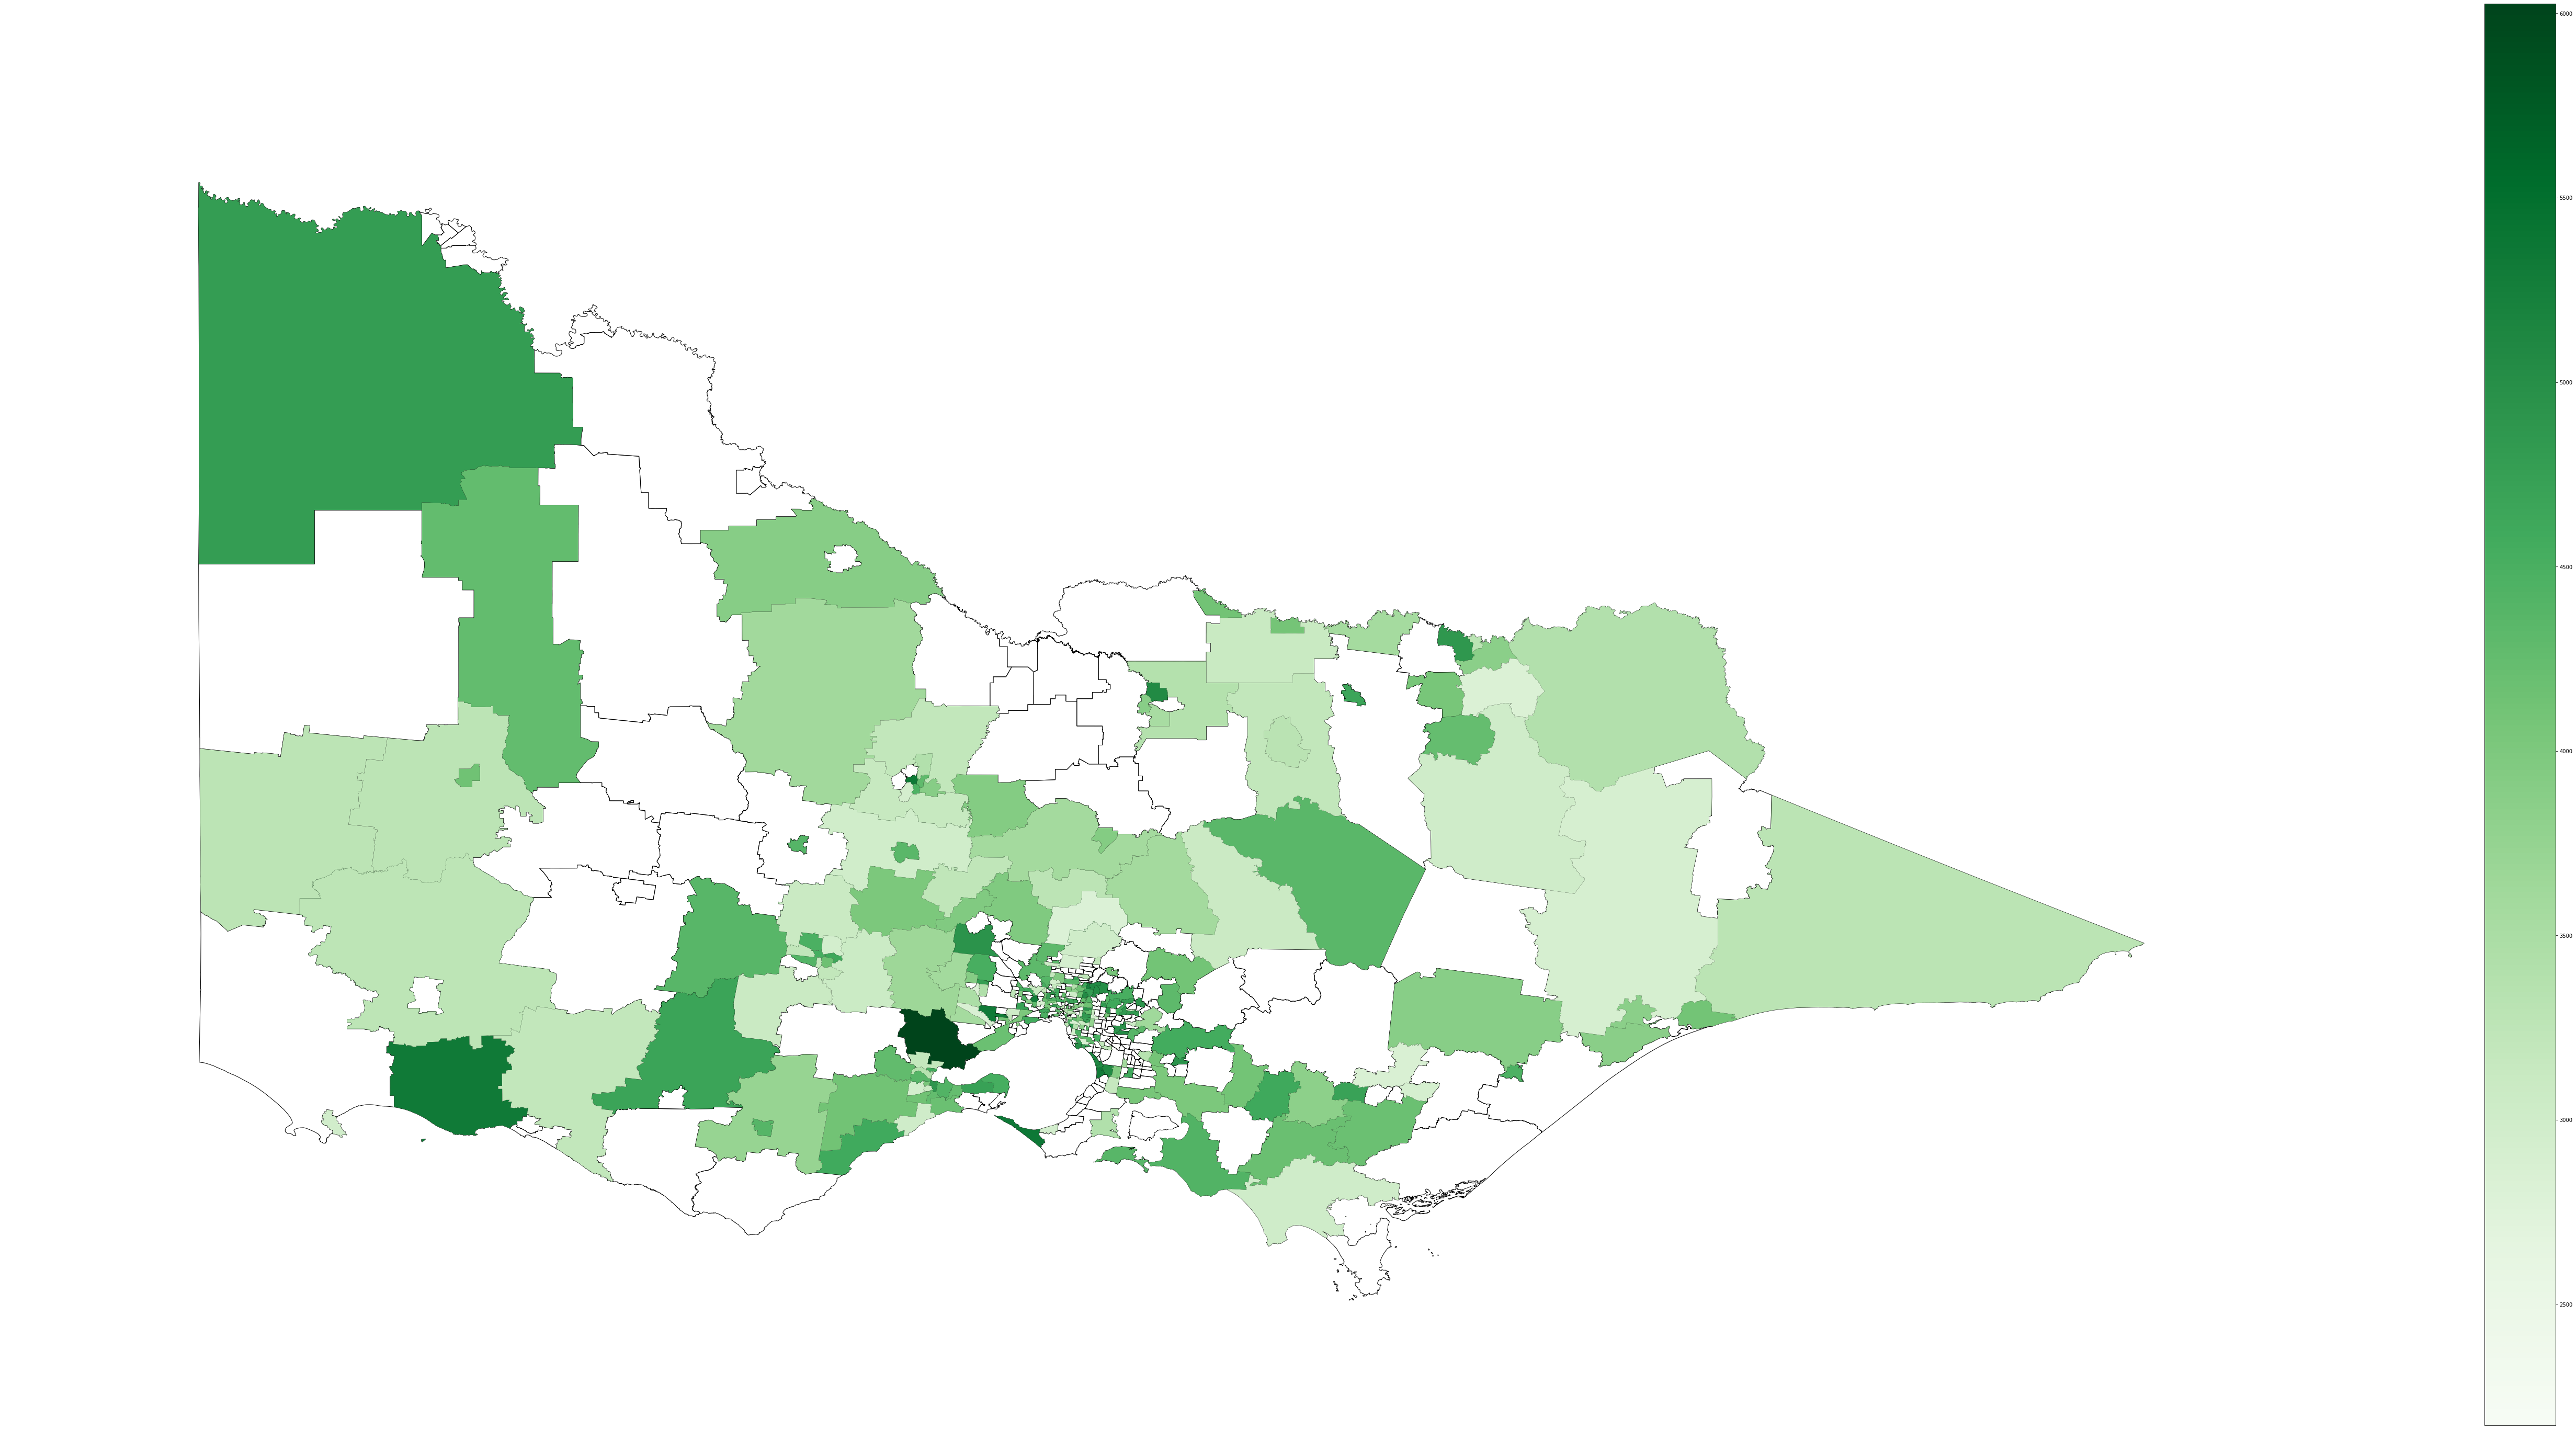

In [172]:
from matplotlib.pyplot import figure
import geoplot.crs as gcrs


ax = gplt.polyplot(shape, figsize=(100, 50))#, projection=gcrs.AlbersEqualArea())

gplt.choropleth(
  gpd.GeoDataFrame(plot_df),
  hue="sum",
  edgecolor="black",
  linewidth=0.1,
  cmap="Greens",
  legend=True,
  ax=ax
)

This graphic shows the results per SA2 zone, but because they don't line up with the suburbs very well, so we get a lot of missing values.